# 공통 설정

In [84]:
!pip install pydicom

You should consider upgrading via the '/usr/bin/python3.8 -m pip install --upgrade pip' command.


In [85]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns
import torch.nn as nn

In [86]:
root = '/root'

In [87]:
import glob

L_list = glob.glob(f'{root}/mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [88]:
data_label = ['quarter_1mm', 'full_1mm']

In [89]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [90]:
import pandas as pd

# organ_probs.csv 파일 불러오기
organ_probs_df = pd.read_csv(f"{root}/organ_probs.csv")
organ_probs_df.head(1)

,File_Path,skull,ventricles,lungs,mediastinum,liver,kidneys,pancreas,spleen,abdominal aorta,spine,lymph nodes
0,/content/drive/MyDrive/mayo2016/L067/quarter_1...,2.140607e-08,0.00043,0.978917,0.018699,0.000021,0.000003,0.000001,0.001919,2.020908e-07,0.000009,7.648957e-07


# 1. moanet - patch

## 데이터셋 불러오기

In [91]:
patch_size = 55
def extract_patches(img, patch_size=patch_size, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55, numpy

In [92]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []

    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [93]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [94]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list, organ_probs_df):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.organ_probs_df = organ_probs_df
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir # 리스트 + 리스트 = 리스트
            y_dir_list += y_dir

        for i, (X_dir, y_dir) in tqdm(enumerate(zip(X_dir_list, y_dir_list)), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            organ_prob = torch.tensor([float(v) for v in organ_probs_df.iloc[i, 1:].values], dtype=torch.float32) # organ_prob을 tensor로 변환

            for j in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[j]).float(), torch.from_numpy(y_patches[j]).float() # torch로 넣어주자.
                self.image_pairs.append((X_patch, organ_prob, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = (self.image_pairs[idx][0], self.image_pairs[idx][1])
        y = self.image_pairs[idx][2]
        return X, y

In [95]:
# 파일 경로 설정

folder_name = f'{root}/dataset_add_prob/'
test_path = folder_name+'test_dataset.pt'
test_dataset = torch.load(test_path) # , weights_only=False

batch_size = 16
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

len(test_loader)

6025

## 평가지표 계산하기

In [96]:
!pwd

/root/moanet_whole


In [97]:
%cd {root}/moanet

/root/moanet


In [98]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [99]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, num_organs=11):  # num_organs = len(text_descriptions)
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2  # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, num_organs, kernel_size=kernel_size, padding=padding, bias=False)  # 장기별 attention
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x, organ_prob):
        """
        Args:
            x (torch.Tensor): Input feature map [B, C, H, W]
            organ_prob (torch.Tensor): Organ probability vector [B, num_organs]
        Returns:
            torch.Tensor: Attention-weighted feature map [B, C, H, W]
        """

        B, C, H, W = x.shape  # 배치 크기, 채널 수, 높이, 너비

        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Average pooling -> [B, 1, H, W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling -> [B, 1, H, W]
        combined = torch.cat([avg_out, max_out], dim=1)  # [B, 2, H, W]

        # 2D Convolution 적용하여 여러 장기의 attention map 생성
        attention = self.sigmoid(self.conv(combined))  # [B, num_organs, H, W]
        self.last_attention = attention  # Attention 저장

        # organ_prob을 attention과 동일한 차원으로 변환하여 element-wise 곱셈
        organ_prob = organ_prob.view(B, -1, 1, 1)  # [B, num_organs, 1, 1]
        weighted_attention = attention * organ_prob  # [B, num_organs, H, W] 각 장기별 확률 반영

        # 장기별 attention을 합산하여 최종 attention map 생성
        final_attention = torch.sum(weighted_attention, dim=1, keepdim=True)  # [B, 1, H, W]

        # 입력 `x`에 최종 attention을 적용
        output = x * final_attention  # [B, C, H, W]

        return output

In [100]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x, prob):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x, prob)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x, prob)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [101]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('moanet.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
        X_hat = model(X, prob)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  17%|█▋        | 1017/6025 [00:11<01:00, 82.33it/s]

RMSE per interval: 0.0464, PSNR per interval: 27.50, SSIM per interval: 0.6767


Evaluating:  33%|███▎      | 2013/6025 [00:23<00:46, 85.64it/s]

RMSE per interval: 0.0437, PSNR per interval: 28.30, SSIM per interval: 0.6920


Evaluating:  50%|█████     | 3013/6025 [00:34<00:32, 91.78it/s]

RMSE per interval: 0.0441, PSNR per interval: 28.43, SSIM per interval: 0.7033


Evaluating:  67%|██████▋   | 4013/6025 [00:45<00:21, 94.37it/s]

RMSE per interval: 0.0377, PSNR per interval: 29.43, SSIM per interval: 0.7283


Evaluating:  83%|████████▎ | 5010/6025 [00:56<00:21, 46.29it/s]

RMSE per interval: 0.0373, PSNR per interval: 29.53, SSIM per interval: 0.7063


Evaluating: 100%|█████████▉| 6012/6025 [01:11<00:00, 93.35it/s]

RMSE per interval: 0.0352, PSNR per interval: 30.25, SSIM per interval: 0.7477


Evaluating: 100%|██████████| 6025/6025 [01:12<00:00, 83.41it/s]

Average RMSE over all intervals: 0.040716


In [102]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [103]:
rmse_list = loss_list
rmse_list

[0.04640608758851886,
 0.04365408520959318,
 0.04405701654497534,
 0.0376762955673039,
 0.03727914898004383,
 0.03522422835417092]

In [104]:
!pwd

/root/moanet


In [105]:
# 저장하는 코드

import pandas as pd

# 데이터프레임 생성
df = pd.DataFrame({
    "RMSE": loss_list,
    "PSNR": psnr_list,
    "SSIM": ssim_list
})

# CSV 파일 저장
csv_filename = f"{root}/moanet/results.csv"
df.to_csv(csv_filename, index=False)

print(f"저장 완료: {csv_filename}")

저장 완료: /root/moanet/results.csv


In [106]:
# 불러오는 코드

import pandas as pd

# CSV 파일 불러오기
csv_filename = f"{root}/moanet/results.csv"
df = pd.read_csv(csv_filename)

# 불러온 데이터 출력
print(df,'\n')

# 개별 리스트로 변환
loss_list = df["RMSE"].tolist()
psnr_list = df["PSNR"].tolist()
ssim_list = df["SSIM"].tolist()

# 확인 출력
print("RMSE List:", loss_list)
print("PSNR List:", psnr_list)
print("SSIM List:", ssim_list)

       RMSE       PSNR      SSIM
0  0.046406  27.496441  0.676724
1  0.043654  28.296787  0.692043
2  0.044057  28.430708  0.703343
3  0.037676  29.428038  0.728304
4  0.037279  29.534533  0.706299
5  0.035224  30.251236  0.747696 

RMSE List: [0.0464060875885188, 0.0436540852095931, 0.0440570165449753, 0.0376762955673039, 0.0372791489800438, 0.0352242283541709]
PSNR List: [27.496440604406093, 28.296786974126256, 28.43070846532849, 29.42803834846071, 29.534532576180325, 30.251235507527305]
SSIM List: [0.6767239966640292, 0.6920425939056176, 0.7033426752890447, 0.7283039646501005, 0.706298564014027, 0.7476956784078893]


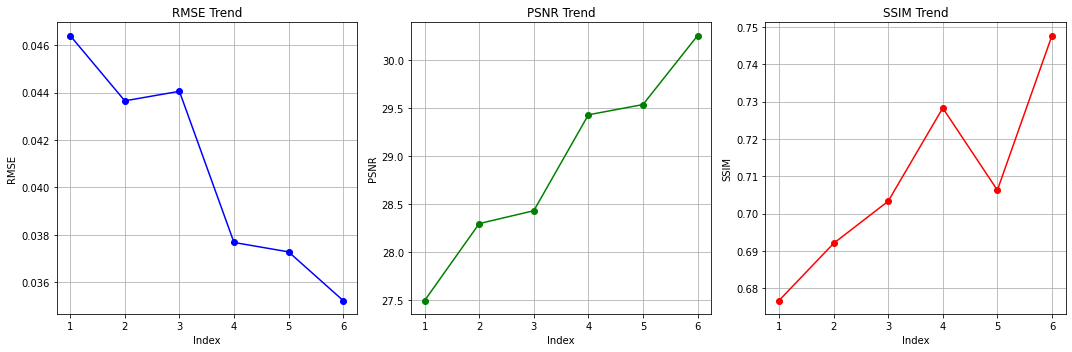

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# 그래프 인덱스 (각 값의 순서를 나타냄)
x_values = np.arange(1, 7)

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].plot(x_values, rmse_list, marker='o', linestyle='-', color='b', label="RMSE")
axs[0].set_title('RMSE Trend')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('RMSE')
axs[0].grid(True)

# PSNR 그래프
axs[1].plot(x_values, psnr_list, marker='o', linestyle='-', color='g', label="PSNR")
axs[1].set_title('PSNR Trend')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('PSNR')
axs[1].grid(True)

# SSIM 그래프
axs[2].plot(x_values, ssim_list, marker='o', linestyle='-', color='r', label="SSIM")
axs[2].set_title('SSIM Trend')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('SSIM')
axs[2].grid(True)

# 그래프 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

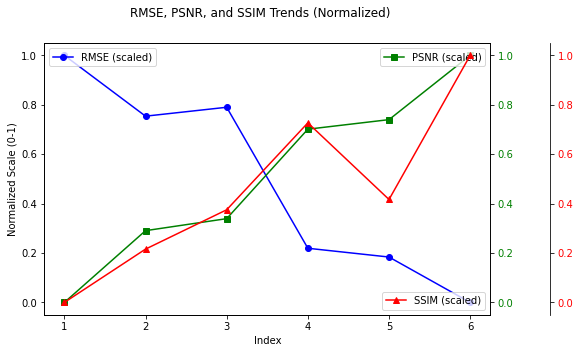

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# 정규화 함수 (min-max scaling)
def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# 정규화
rmse_scaled = min_max_scale(rmse_list)
psnr_scaled = min_max_scale(psnr_list)
ssim_scaled = min_max_scale(ssim_list)

# 그래프 인덱스
x_values = np.arange(1, len(rmse_list) + 1)

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(8, 5))

# RMSE (파란색 원)
ax1.plot(x_values, rmse_scaled, marker='o', linestyle='-', color='b', label="RMSE (scaled)")
ax1.set_ylabel("Normalized Scale (0-1)", color='black')
ax1.set_xlabel("Index")
ax1.tick_params(axis='y', labelcolor='black')

# PSNR (초록색 사각형, 보조 y축)
ax2 = ax1.twinx()
ax2.plot(x_values, psnr_scaled, marker='s', linestyle='-', color='g', label="PSNR (scaled)")
ax2.tick_params(axis='y', labelcolor='g')

# SSIM (빨간색 삼각형, 추가 y축)
ax3 = ax1.twinx()
ax3.plot(x_values, ssim_scaled, marker='^', linestyle='-', color='r', label="SSIM (scaled)")
ax3.spines['right'].set_position(("outward", 60))  # 세 번째 y축을 오른쪽 바깥으로 조정
ax3.tick_params(axis='y', labelcolor='r')

# 제목 및 범례
fig.suptitle("RMSE, PSNR, and SSIM Trends (Normalized)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

# 그래프 표시
plt.show()

In [109]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0407 ± 0.0042
PSNR: 28.9063 ± 0.9184
SSIM: 0.7091 ± 0.0232


# 2. moanet_whole

## 데이터셋 불러오기

In [110]:
patch_size = 512
def extract_patches(img, patch_size=patch_size, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55, numpy

In [111]:
import random
from scipy.ndimage import rotate, zoom

def augment_patches(X_patches, y_patches, p=0.5):
    X_augmented_patches, y_augmented_patches = [], []

    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [112]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [113]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list, organ_probs_df):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.organ_probs_df = organ_probs_df
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir # 리스트 + 리스트 = 리스트
            y_dir_list += y_dir

        for i, (X_dir, y_dir) in tqdm(enumerate(zip(X_dir_list, y_dir_list)), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            organ_prob = torch.tensor([float(v) for v in organ_probs_df.iloc[i, 1:].values], dtype=torch.float32) # organ_prob을 tensor로 변환

            for j in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[j]).float(), torch.from_numpy(y_patches[j]).float() # torch로 넣어주자.
                self.image_pairs.append((X_patch, organ_prob, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'{root}/mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)

        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = (self.image_pairs[idx][0], self.image_pairs[idx][1])
        y = self.image_pairs[idx][2]
        return X, y

In [114]:
# 파일 경로 설정

folder_name = f'{root}/dataset_add_prob_whole/'
test_path = folder_name+'test_dataset.pt'
test_dataset = torch.load(test_path) # , weights_only=False

batch_size = 1
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

len(test_loader)

1190

## 평가지표 계산하기

In [115]:
!pwd

/root/moanet


In [116]:
%cd {root}/moanet_whole

/root/moanet_whole


In [117]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [118]:
import torch
import torch.nn as nn

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, num_organs=11):  # num_organs = len(text_descriptions)
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), "Kernel size must be 3 or 7"
        padding = (kernel_size - 1) // 2  # 동일한 크기를 유지하기 위한 패딩
        self.conv = nn.Conv2d(2, num_organs, kernel_size=kernel_size, padding=padding, bias=False)  # 장기별 attention
        self.sigmoid = nn.Sigmoid()
        self.last_attention = None  # Attention 값을 저장하는 변수

    def forward(self, x, organ_prob):
        """
        Args:
            x (torch.Tensor): Input feature map [B, C, H, W]
            organ_prob (torch.Tensor): Organ probability vector [B, num_organs]
        Returns:
            torch.Tensor: Attention-weighted feature map [B, C, H, W]
        """

        B, C, H, W = x.shape  # 배치 크기, 채널 수, 높이, 너비

        # 채널 차원을 압축 (Max Pooling과 Average Pooling)
        avg_out = torch.mean(x, dim=1, keepdim=True)  # Average pooling -> [B, 1, H, W]
        max_out, _ = torch.max(x, dim=1, keepdim=True)  # Max pooling -> [B, 1, H, W]
        combined = torch.cat([avg_out, max_out], dim=1)  # [B, 2, H, W]

        # 2D Convolution 적용하여 여러 장기의 attention map 생성
        attention = self.sigmoid(self.conv(combined))  # [B, num_organs, H, W]
        self.last_attention = attention  # Attention 저장

        # organ_prob을 attention과 동일한 차원으로 변환하여 element-wise 곱셈
        organ_prob = organ_prob.view(B, -1, 1, 1)  # [B, num_organs, 1, 1]
        weighted_attention = attention * organ_prob  # [B, num_organs, H, W] 각 장기별 확률 반영

        # 장기별 attention을 합산하여 최종 attention map 생성
        final_attention = torch.sum(weighted_attention, dim=1, keepdim=True)  # [B, 1, H, W]

        # 입력 `x`에 최종 attention을 적용
        output = x * final_attention  # [B, C, H, W]

        return output

In [119]:
class RedCNNWithSpatialAttention(nn.Module):
    def __init__(self):
        super(RedCNNWithSpatialAttention, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)

        # Spatial Attention Blocks
        self.spatial_attention3 = SpatialAttention()
        self.spatial_attention5 = SpatialAttention()

        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()

    def forward(self, x, prob):
        # 인코더 부분
        residual1 = x
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x
        x = self.relu(self.conv3(x))
        x = self.spatial_attention3(x, prob)  # Spatial Attention (3번째 위치)
        x = self.relu(self.conv4(x))
        residual3 = x
        x = self.relu(self.conv5(x))
        x = self.spatial_attention5(x, prob)  # Spatial Attention (5번째 위치)

        # 디코더 부분
        x = self.relu(self.deconv1(x) + residual3)
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x) + residual2)
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1

        return x

In [120]:
import torch
import torch.nn as nn
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm

criterion = nn.MSELoss()
interval = 1000//((512/55)**2/16)

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNNWithSpatialAttention().to(device)
model.load_state_dict(torch.load('moanet_whole.pth'))

# 평가 지표 계산 추가
def calculate_psnr(y_true, y_pred):
    """PSNR 계산 함수"""
    y_true = y_true.cpu().numpy()
    y_pred = y_pred.cpu().numpy()
    return peak_signal_noise_ratio(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

def calculate_ssim(y_true, y_pred):
    """SSIM 계산 함수"""
    y_true = y_true.squeeze(0).cpu().numpy()
    y_pred = y_pred.squeeze(0).cpu().numpy()
    return structural_similarity(y_true, y_pred, data_range=1.0)  # 정규화된 데이터라면 data_range=1.0

# evaluate 부분 + top10 best&worst
model.eval()
running_loss = 0.0
running_psnr = 0.0
running_ssim = 0.0
psnr_list = []
ssim_list = []
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, prob, y = data[0][0].to(device), data[0][1].to(device), data[1].to(device)
        X_hat = model(X, prob)
        mse_loss = criterion(X_hat, y)

        # RMSE 계산
        rms_loss = torch.sqrt(mse_loss)
        running_loss += rms_loss.item()

        # PSNR, SSIM 계산
        for j in range(X.size(0)):  # 배치 내부 개별 이미지에 대해 계산
            psnr = calculate_psnr(y[j, :, :, :], X_hat[j, :, :, :])
            ssim = calculate_ssim(y[j, :, :, :], X_hat[j, :, :, :])
            running_psnr += psnr # batch에 대해 더해준다.
            running_ssim += ssim

        if mse_loss < best_loss:
            best_loss = mse_loss
            best = (X, y, X_hat)
        if mse_loss > worst_loss:
            worst_loss = mse_loss
            worst = (X, y, X_hat)

        if i % interval == interval - 1:
            interval_loss = running_loss / interval
            interval_psnr = running_psnr / (interval * X.size(0)) # batch에 대해 나눠준다
            interval_ssim = running_ssim / (interval * X.size(0))

            loss_list.append(interval_loss)
            psnr_list.append(interval_psnr)
            ssim_list.append(interval_ssim)

            total_loss += interval_loss
            running_loss = 0.0
            running_psnr = 0.0
            running_ssim = 0.0
            tqdm.write(f'RMSE per interval: {interval_loss:.4f}, PSNR per interval: {interval_psnr:.2f}, SSIM per interval: {interval_ssim:.4f}')
            # tqdm.write(f'RMSE per interval: {interval_loss}, PSNR per interval: {interval_psnr}, SSIM per interval: {interval_ssim}')

    # 평균 RMSE 출력
average_loss = total_loss / len(loss_list)
print(f"Average RMSE over all intervals: {average_loss:.6f}")

Evaluating:  16%|█▌        | 187/1190 [00:08<00:36, 27.27it/s]

RMSE per interval: 0.0469, PSNR per interval: 26.60, SSIM per interval: 0.6717


Evaluating:  31%|███▏      | 373/1190 [00:14<00:29, 27.73it/s]

RMSE per interval: 0.0424, PSNR per interval: 27.59, SSIM per interval: 0.7052


Evaluating:  47%|████▋     | 556/1190 [00:22<00:25, 25.19it/s]

RMSE per interval: 0.0474, PSNR per interval: 26.59, SSIM per interval: 0.6815


Evaluating:  62%|██████▏   | 739/1190 [00:28<00:15, 28.72it/s]

RMSE per interval: 0.0375, PSNR per interval: 28.52, SSIM per interval: 0.7332


Evaluating:  78%|███████▊  | 925/1190 [00:35<00:09, 28.42it/s]

RMSE per interval: 0.0388, PSNR per interval: 28.23, SSIM per interval: 0.6974


Evaluating:  93%|█████████▎| 1108/1190 [00:41<00:02, 28.68it/s]

RMSE per interval: 0.0377, PSNR per interval: 28.49, SSIM per interval: 0.7259


Evaluating: 100%|██████████| 1190/1190 [00:44<00:00, 26.71it/s]

Average RMSE over all intervals: 0.041782


In [121]:
len(loss_list), len(psnr_list), len(ssim_list)

(6, 6, 6)

In [122]:
rmse_list = loss_list
rmse_list

[0.0469143782823306,
 0.04236783014367456,
 0.04736378946867974,
 0.037548036557500775,
 0.03879371538515324,
 0.03770645697722617]

In [123]:
!pwd

/root/moanet_whole


In [124]:
# 저장하는 코드

import pandas as pd

# 데이터프레임 생성
df = pd.DataFrame({
    "RMSE": loss_list,
    "PSNR": psnr_list,
    "SSIM": ssim_list
})

# CSV 파일 저장
csv_filename = f"{root}/moanet_whole/results.csv"
df.to_csv(csv_filename, index=False)

print(f"저장 완료: {csv_filename}")

저장 완료: /root/moanet_whole/results.csv


In [125]:
# 불러오는 코드

import pandas as pd

# CSV 파일 불러오기
csv_filename = f"{root}/moanet_whole/results.csv"
df = pd.read_csv(csv_filename)

# 불러온 데이터 출력
print(df,'\n')

# 개별 리스트로 변환
loss_list = df["RMSE"].tolist()
psnr_list = df["PSNR"].tolist()
ssim_list = df["SSIM"].tolist()

# 확인 출력
print("RMSE List:", loss_list)
print("PSNR List:", psnr_list)
print("SSIM List:", ssim_list)

       RMSE       PSNR      SSIM
0  0.046914  26.595584  0.671670
1  0.042368  27.591176  0.705189
2  0.047364  26.589263  0.681476
3  0.037548  28.524940  0.733199
4  0.038794  28.230289  0.697380
5  0.037706  28.492721  0.725916 

RMSE List: [0.0469143782823306, 0.0423678301436745, 0.0473637894686797, 0.0375480365575007, 0.0387937153851532, 0.0377064569772261]
PSNR List: [26.595583907155984, 27.591175961762342, 26.589262511518324, 28.52493993182182, 28.23028931965584, 28.492721053260816]
SSIM List: [0.6716703458502987, 0.705189013194689, 0.6814764170072288, 0.7331987558291782, 0.6973799482594628, 0.7259158645496371]


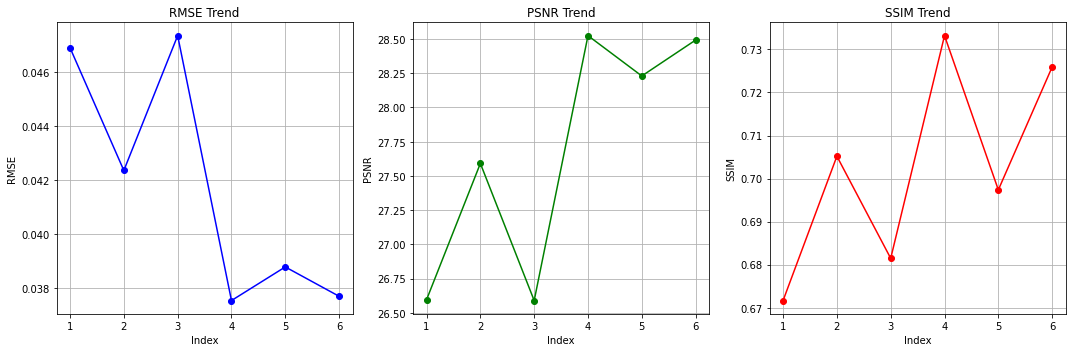

In [126]:
import numpy as np
import matplotlib.pyplot as plt

# 그래프 인덱스 (각 값의 순서를 나타냄)
x_values = np.arange(1, 7)

# 그래프 그리기
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
axs[0].plot(x_values, rmse_list, marker='o', linestyle='-', color='b', label="RMSE")
axs[0].set_title('RMSE Trend')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('RMSE')
axs[0].grid(True)

# PSNR 그래프
axs[1].plot(x_values, psnr_list, marker='o', linestyle='-', color='g', label="PSNR")
axs[1].set_title('PSNR Trend')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('PSNR')
axs[1].grid(True)

# SSIM 그래프
axs[2].plot(x_values, ssim_list, marker='o', linestyle='-', color='r', label="SSIM")
axs[2].set_title('SSIM Trend')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('SSIM')
axs[2].grid(True)

# 그래프 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

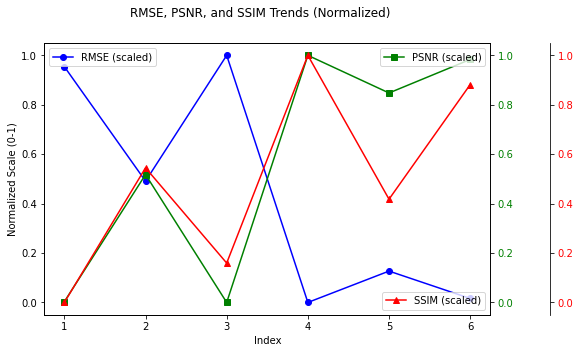

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# 정규화 함수 (min-max scaling)
def min_max_scale(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# 정규화
rmse_scaled = min_max_scale(rmse_list)
psnr_scaled = min_max_scale(psnr_list)
ssim_scaled = min_max_scale(ssim_list)

# 그래프 인덱스
x_values = np.arange(1, len(rmse_list) + 1)

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(8, 5))

# RMSE (파란색 원)
ax1.plot(x_values, rmse_scaled, marker='o', linestyle='-', color='b', label="RMSE (scaled)")
ax1.set_ylabel("Normalized Scale (0-1)", color='black')
ax1.set_xlabel("Index")
ax1.tick_params(axis='y', labelcolor='black')

# PSNR (초록색 사각형, 보조 y축)
ax2 = ax1.twinx()
ax2.plot(x_values, psnr_scaled, marker='s', linestyle='-', color='g', label="PSNR (scaled)")
ax2.tick_params(axis='y', labelcolor='g')

# SSIM (빨간색 삼각형, 추가 y축)
ax3 = ax1.twinx()
ax3.plot(x_values, ssim_scaled, marker='^', linestyle='-', color='r', label="SSIM (scaled)")
ax3.spines['right'].set_position(("outward", 60))  # 세 번째 y축을 오른쪽 바깥으로 조정
ax3.tick_params(axis='y', labelcolor='r')

# 제목 및 범례
fig.suptitle("RMSE, PSNR, and SSIM Trends (Normalized)")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
ax3.legend(loc="lower right")

# 그래프 표시
plt.show()

In [128]:
# 평균(mean)과 표준편차(sd) 계산
rmse_mean = np.mean(rmse_list)
rmse_sd = np.std(rmse_list)

psnr_mean = np.mean(psnr_list)
psnr_sd = np.std(psnr_list)

ssim_mean = np.mean(ssim_list)
ssim_sd = np.std(ssim_list)

# 결과를 mean ± sd 형식으로 표현
rmse_result = f"{rmse_mean:.4f} ± {rmse_sd:.4f}"
psnr_result = f"{psnr_mean:.4f} ± {psnr_sd:.4f}"
ssim_result = f"{ssim_mean:.4f} ± {ssim_sd:.4f}"

# 결과 출력
print(f"RMSE: {rmse_result}")
print(f"PSNR: {psnr_result}")
print(f"SSIM: {ssim_result}")

RMSE: 0.0418 ± 0.0041
PSNR: 27.6707 ± 0.8216
SSIM: 0.7025 ± 0.0220


# 최종결과비교

In [129]:
import pandas as pd

# CSV 파일 경로 설정
csv_paths = {
    "moanet_patch": f"{root}/moanet/results.csv",
    "moanet_whole": f"{root}/moanet_whole/results.csv"
}

# 각 파일을 읽어와서 데이터프레임으로 저장
df_dict = {}
for name, path in csv_paths.items():
    df = pd.read_csv(path)
    df_dict[name] = df
df_dict

{'moanet_patch':        RMSE       PSNR      SSIM
 0  0.046406  27.496441  0.676724
 1  0.043654  28.296787  0.692043
 2  0.044057  28.430708  0.703343
 3  0.037676  29.428038  0.728304
 4  0.037279  29.534533  0.706299
 5  0.035224  30.251236  0.747696,
 'moanet_whole':        RMSE       PSNR      SSIM
 0  0.046914  26.595584  0.671670
 1  0.042368  27.591176  0.705189
 2  0.047364  26.589263  0.681476
 3  0.037548  28.524940  0.733199
 4  0.038794  28.230289  0.697380
 5  0.037706  28.492721  0.725916}

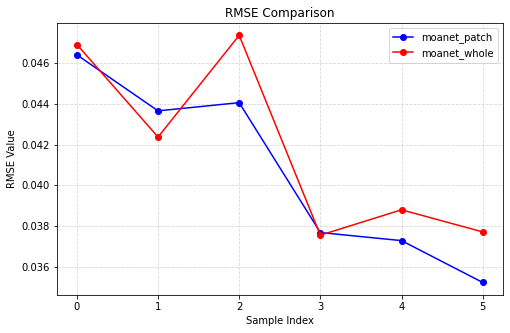

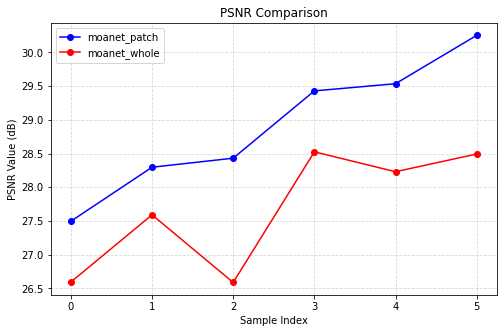

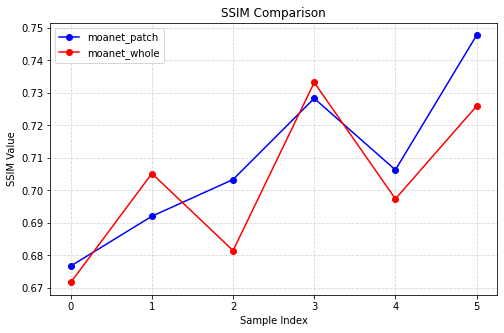

In [130]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 리스트
model_names = ["moanet_patch", "moanet_whole"]
colors = ["b", "r"]  # 각 모델별 색상 지정

# 그래프 그리는 함수
def plot_metric(metric_name, ylabel):
    plt.figure(figsize=(8, 5))  # 그래프 크기 설정

    for model, color in zip(model_names, colors):
        metric_values = df_dict[model][metric_name].values  # 모델별 해당 지표 값 가져오기
        x_axis = np.arange(len(metric_values))  # X축: 데이터 인덱스
        plt.plot(x_axis, metric_values, marker="o", linestyle="-", color=color, label=model)

    plt.xlabel("Sample Index")
    plt.ylabel(ylabel)
    plt.title(f"{metric_name} Comparison")
    plt.legend()  # 모델 구분을 위한 legend 추가
    plt.grid(True, linestyle="--", alpha=0.5)  # 격자 추가
    plt.show()

# RMSE 그래프
plot_metric("RMSE", "RMSE Value")

# PSNR 그래프
plot_metric("PSNR", "PSNR Value (dB)")

# SSIM 그래프
plot_metric("SSIM", "SSIM Value")

/tmp/ipykernel_254063/823618216.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전
/tmp/ipykernel_254063/823618216.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전
/tmp/ipykernel_254063/823618216.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전


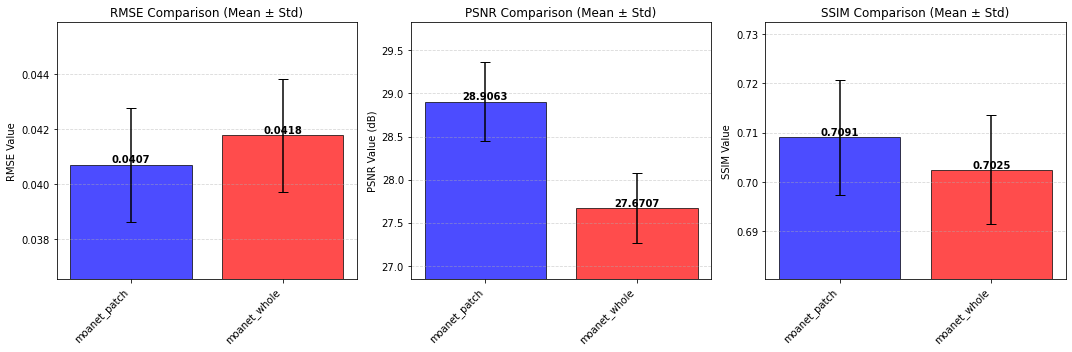

In [131]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 리스트 및 색상 설정
model_names = ["moanet_patch", "moanet_whole"]
colors = ["b", "r"]  # 각 모델별 색상 지정

# 그래프 그리는 함수 (평균 + 표준편차)
def plot_mean_std(ax, metric_name, ylabel):
    x_labels = model_names  # X축에 모델 이름 표시
    means = []  # 평균값 저장 리스트
    stds = []   # 표준편차 저장 리스트

    for model in model_names:
        metric_values = df_dict[model][metric_name].values  # 해당 모델의 지표 값 가져오기
        means.append(np.mean(metric_values))  # 평균
        stds.append(np.std(metric_values))  # 표준편차

    # 리스트를 NumPy 배열로 변환
    means = np.array(means)
    stds = np.array(stds)

    # y축 범위 설정 (최소/최대값 + 표준편차의 3배)
    ymin = np.min(means-stds)
    ymax = np.max(means+stds)
    ax.set_ylim(ymin, ymax)

    # 막대그래프 (오차 막대 포함)
    bars = ax.bar(x_labels, means, yerr=stds / 2, capsize=5, color=colors, alpha=0.7, edgecolor="black")

    # 막대 위에 평균값 표시
    for bar, mean in zip(bars, means):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{mean:.4f}",
                ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    ax.set_xticklabels(x_labels, rotation=45, ha="right")  # X축 레이블 회전
    ax.set_ylabel(ylabel)
    ax.set_title(f"{metric_name} Comparison (Mean ± Std)")
    ax.grid(axis="y", linestyle="--", alpha=0.5)  # y축 격자 추가

# 1행 3열 그래프 생성
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# RMSE 그래프
plot_mean_std(axes[0], "RMSE", "RMSE Value")

# PSNR 그래프
plot_mean_std(axes[1], "PSNR", "PSNR Value (dB)")

# SSIM 그래프
plot_mean_std(axes[2], "SSIM", "SSIM Value")

plt.tight_layout()
plt.show()
